# **Coronavirus tweets-Text Classification**

#### Autore: Martina Cavallucci
#### Email: nome.cognome@studio.unibo.it
#### Release: Gennaio, 2020

*Questo script R esegue un' analisi e una classificazione di testi di tweet durante il perodo di Marzo 2019 e Aprile 2019.
Tali tweet si riferiscono ad un topic specifico: Covid-19.
L'obiettivo è quindi comprendere le relazioni tra i termini utilizzati, e la classificazione dei tweet rispetto al sentiment (Positive, Negative, Neutral).*



---

#### Import delle librerie R e di Text Mining

---




In [1]:
install.packages("lsa")
install.packages("tm")
install.packages("RWeka")
install.packages("data.table") 
install.packages("checkmate")
install.packages("stringr") 
library(data.table)
library(tidyverse)
library(tm)
library(lsa)
library(RWeka)
library(tidyverse)
if(!require("R.utils"))
  install.packages("R.utils")
library("R.utils")
library(checkmate)
library(stringr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘SnowballC’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘NLP’, ‘slam’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RWekajars’, ‘rJava’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::betwe

---

#### Import del text set su Github

---


In [2]:
download.file('https://github.com/CavallucciMartina/Coronavirus-tweets-Text-Classification/blob/main/input/Corona_NLP_test.csv.gz?raw=true', 'test.csv.gz') #, method="curl")
gunzip('test.csv.gz')
download.file('https://github.com/CavallucciMartina/Coronavirus-tweets-Text-Classification/blob/main/input/Corona_NLP_train.csv.gz?raw=true', 'train.csv.gz') #, method="curl")
gunzip('train.csv.gz')


---

#### Prima visualizzazione del train set

---


In [3]:
train <- read.csv("train.csv")
test <- read.csv("test.csv")
head(train)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
,<int>,<int>,<chr>,<chr>,<chr>,<chr>
1,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
2,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive
3,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
4,3802,48754,,16-03-2020,"My food stock is not the only one which is empty... PLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. Stay calm, stay safe. #COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive
5,3803,48755,,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak. Not because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage... #CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Extremely Negative
6,3804,48756,"ÜT: 36.319708,-82.363649",16-03-2020,"As news of the regions first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports https://t.co/cfXch7a2lU",Positive


---

#### Dimensioni del train set e del test set

---


In [4]:
dim(train)
dim(test)

[1] 41157     6

[1] 3798    6


---

#### Preparazione analisi risultati di Sentiment in Train

---

In [5]:
library(tidyverse)
districtSentiment = count(train,Sentiment)
districtSentiment[,c(2)]

[1]  5481  6624  9917  7713 11422

---

#### Grafico delle percentuali di sentiment nel train set

---

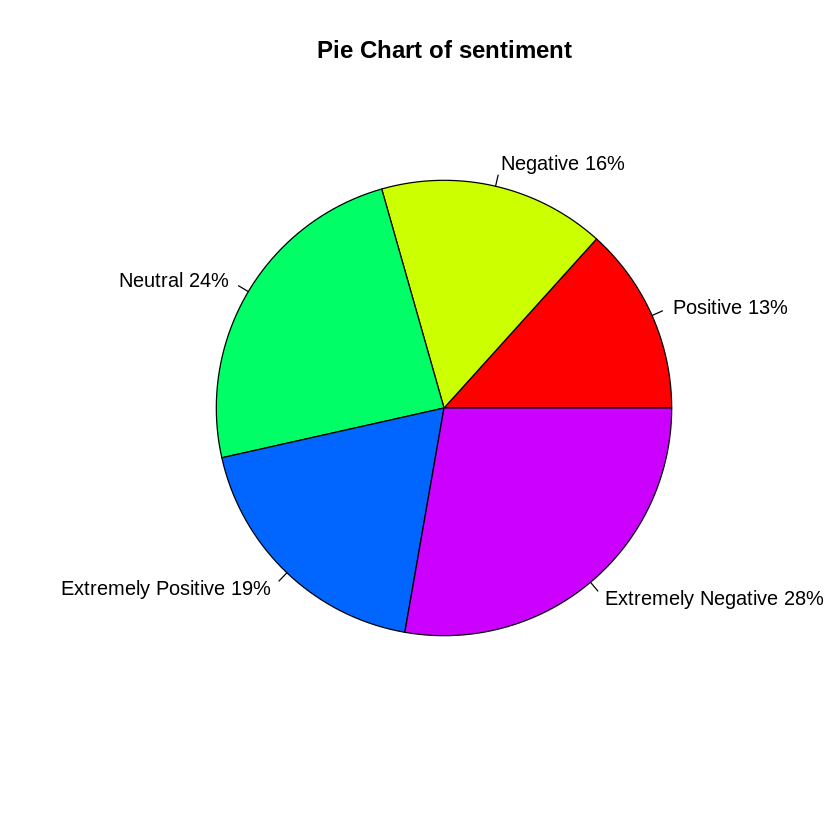

In [6]:
sentiment <- c(districtSentiment[,c(2)]) 
lbls <- c('Positive','Negative','Neutral','Extremely Positive','Extremely Negative')
pct <- round(sentiment/sum(sentiment)*100)
lbls <- paste(lbls, pct) # add percents to labels
lbls <- paste(lbls,"%",sep="") # ad % to labels
pie(sentiment,labels = lbls, col=rainbow(length(lbls)),
   main="Pie Chart of sentiment") 

In [ ]:
y=copy(train$Sentiment )

---

#### Preparazione train per classificazione; trasformazione da 5 classi a 3: Positive, Negative, Neutral

---

In [7]:
new_train = data.frame(
                text = train$OriginalTweet,
                labels = train$Sentiment,
                stringsAsFactors=F)

new_test = data.frame(
                text = test$OriginalTweet,
                labels = test$Sentiment,
                stringsAsFactors=F)


In [8]:
# Data has 5 classes, let's convert them to 3

classes_def <- function(x)
    if (x ==  "Extremely Positive"){
         "2"
    }else if( x == "Extremely Negative"){
         "0"
    }else if(x == "Negative"){
         "0"
    }else if(x ==  "Positive"){
         "2"
    }else {
         "1"
    }


new_train$labels = lapply(new_train$labels, function(x) classes_def(x))
new_test$labels = lapply(new_test$labels, function(x) classes_def(x))
#new_train$labels.value_counts(normalize= True)

---

#### Creazione del corpus

---

In [ ]:
install.packages("quanteda") 
library(quanteda)

In [ ]:
corp_immig <- corpus(new_train)
summary(corp_immig)


In [ ]:
texts(corp_immig)[3]
new_train$labels[3]
# 2 -> Positive

In [ ]:
kwic(corp_immig, "covid", window=4)

In [ ]:
kwic(corp_immig, "pandemic", window=6)

---

#### Creazione matrice documenti-termini

---

In [ ]:
doc_term_matrix <- quanteda::dfm(corp_immig,
                                 tolower = TRUE, 
                                 removeNumbers = TRUE,              
                                 stem = FALSE,                
                                 remove_punct = TRUE,  
                                 removeSeparators = TRUE,        
                                 remove = stopwords("english"), 
                                 ngrams = 1) 

---

#### Text cleaning

---

In [114]:
doc_term_matrix <- dfm_select(doc_term_matrix, "(http|https)://([^\\s]+)", selection = "remove", valuetype = "regex")
doc_term_matrix <- dfm_select(doc_term_matrix, "<.*?>", selection = "remove", valuetype = "regex")
doc_term_matrix <- dfm_select(doc_term_matrix, "#\\w+", selection = "remove", valuetype = "regex")
doc_term_matrix <- dfm_select(doc_term_matrix, "@\\w+", selection = "remove", valuetype = "regex")
doc_term_matrix <- dfm_select(doc_term_matrix, "\\d+", selection = "remove", valuetype = "regex")
doc_term_matrix <- dfm_select(doc_term_matrix, "\\s+", selection = "remove", valuetype = "regex")
doc_term_matrix <- dfm_select(doc_term_matrix, "(s|t)", selection = "remove", valuetype = "regex")

In [ ]:
doc_term_matrix[1:5,1:5]

In [ ]:
topfeatures(doc_term_matrix,15)

---

#### Generazione wordcloud

---

In [ ]:
set.seed(100)
textplot_wordcloud(doc_term_matrix, min_count = 200, random_order = FALSE,
                   rotation = .25, 
                   color = RColorBrewer::brewer.pal(8,"Dark2"))

In [ ]:
dict <- featnames(doc_term_matrix)
dict

---

## **Classificazione**

---